In [1]:
# Import packages and set themes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import LanczosCGApproximateGPs as agp
import time
from sklearn.gaussian_process.kernels import Matern
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import svds
import scipy.sparse

sns.set_theme()

In [2]:
# Parameters
sample_size  = 1000
noise_level  = 0.2

# True function
smoothness   = 0.6
def reference_function(x):
    z = np.abs(x - 0.4)**smoothness - np.abs(x - 0.2)**smoothness
    return z

# Simulating random desing sample
X   = np.random.uniform(0, 1, sample_size)
X   = np.sort(X)
X   = np.array([X])
X   = X.transpose()

# Data w/ noise
f0  = reference_function(X[:, 0])
eps = np.random.normal(0, noise_level, sample_size) 
Y   = f0 + eps


In [3]:
kernel = Matern(length_scale = 1.0, nu = smoothness)
kernel_matrix = kernel(X, X)
augmented_kernel_matrix = kernel_matrix + noise_level**2 * np.eye(sample_size)

/tmp/ipykernel_155737/3319212631.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_posterior_variance[i] = true_posterior_covariance(X[i, :], X[i, :])


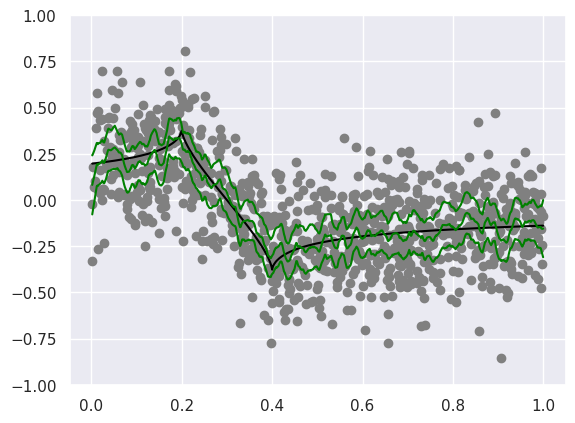

In [4]:
# Inverting the augmented kernel matrix
augmented_inverse = np.linalg.inv(augmented_kernel_matrix)

# Defining the posterior covariance function
def true_posterior_covariance(design_point_1, design_point_2):
    """Returns an the true posterior covariance at the inputs."""

    kernel_vector_at_1 = kernel(X, np.array([design_point_1]))
    kernel_vector_at_2 = kernel(X, np.array([design_point_2]))

    evaluated_kernel     = kernel(np.array([design_point_1]),
                                  np.array([design_point_2]))
    covariance_reduction = kernel_vector_at_1.transpose() @ \
                           augmented_inverse @ kernel_vector_at_2

    return evaluated_kernel - covariance_reduction

# Evaluating true posterior mean/variance
true_posterior_mean = kernel_matrix @ augmented_inverse @ Y
true_posterior_variance = np.zeros(sample_size)
for i in range(sample_size):
    true_posterior_variance[i] = true_posterior_covariance(X[i, :], X[i, :])

# True credible intervals
true_upper_ci = true_posterior_mean + 2 * np.sqrt(true_posterior_variance)
true_lower_ci = true_posterior_mean - 2 * np.sqrt(true_posterior_variance)

# True posterior plot
fig = plt.figure()
plt.scatter(X[:, 0], Y, color = "gray")
plt.plot(X[:, 0], f0,   color = "black")
plt.plot(X[:, 0], true_posterior_mean, color = "green")
plt.plot(X[:, 0], true_upper_ci,       color = "green")
plt.plot(X[:, 0], true_lower_ci,       color = "green")
plt.ylim((-1, 1))
plt.show()

/tmp/ipykernel_281890/3721072414.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lanczos_variance_vector[i] = algorithm.approx_posterior_covariance(X[i, :], X[i, :])


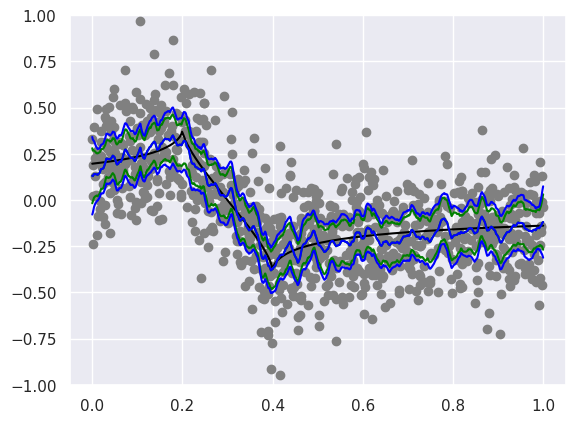

In [12]:
### Lanczos posterior ##########################################################

# Redefining the kernel function to pass to Iter_GP
def matern_kernel(x, y):
    kernel = Matern(length_scale = 1.0, nu = smoothness)
    z = kernel(np.array([x]), np.array([y]))
    z = z.item()
    return z

# Number of approximation and starting vector
number_of_eigenpairs = 50
starting_vector = Y / np.sqrt(np.sum(Y**2))
# starting_vector = np.random.normal(0, noise_level, sample_size)
# starting_vector = starting_vector / np.sqrt(np.sum(starting_vector**2))

# Collecting Lanczos actions w/ time measurement
lanczos_alg = agp.Lanczos(kernel_matrix, starting_vector, number_of_eigenpairs)
lanczos_alg.run()
lanczos_alg.get_eigenquantities()

lanczos_actions = []
for index in range(number_of_eigenpairs):
    action = lanczos_alg.eigenvectors[:, index]
    lanczos_actions.append(action)

# Running the algorithm
algorithm = agp.Iter_GP(X, Y, noise_level, lanczos_actions, kernel)
algorithm.iter_forward(50)

# Lanczos posterior mean/variance
lanczos_posterior_mean = algorithm.approx_posterior_mean(X)
lanczos_variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    lanczos_variance_vector[i] = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

# Lanczos credible intervals
lanczos_upper_ci = lanczos_posterior_mean + 2 * np.sqrt(lanczos_variance_vector)
lanczos_lower_ci = lanczos_posterior_mean - 2 * np.sqrt(lanczos_variance_vector)

# Lanczos posterior plot
fig = plt.figure()
plt.scatter(X[:, 0], Y, color = "gray")
plt.plot(X[:, 0], f0,   color = "black")
plt.plot(X[:, 0], true_posterior_mean, color = "green")
plt.plot(X[:, 0], true_upper_ci,       color = "green")
plt.plot(X[:, 0], true_lower_ci,       color = "green")
plt.plot(X[:, 0], lanczos_posterior_mean, color = "blue")
plt.plot(X[:, 0], lanczos_upper_ci,       color = "blue")
plt.plot(X[:, 0], lanczos_lower_ci,       color = "blue")
plt.ylim((-1, 1))
plt.show()K

### Sampling

### Kernel functions

### Full eigenvector actions

### Lanczos actions

### CG-actions

### Performance CG-algorithm

### Equivalence of CG and Lanczos posteriors
As predicted by our theory, the approximate posteriors from the Lanczos actions and the CG-actions coincide.

### Standard actions (for partial Cholesky)
The standard actions exhibit localization effects.

The posterior mean becomes constant at observation m + 2? No, there can be some slope! Conditional Gaussian, see n = 2.